In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
train_dataset_path = Path('/content/drive/MyDrive/Colab Notebooks/boat_type_classification_dataset/train')
test_dataset_path = Path('/content/drive/MyDrive/Colab Notebooks/boat_type_classification_dataset/test')

'''
train_image_files = list(train_dataset_path.glob(r'**/*.jpg'))
test_image_files = list(test_dataset_path.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_image_files))

test_df = pd.DataFrame()
test_df['test_Image'] = test_image_files
test_df['test_Image'] = test_df['test_Image'].apply(lambda x: str(x))
test_df.head()

train_df = pd.DataFrame()
train_df['Image'] = train_image_files
train_df['Image'] = train_df['Image'].apply(lambda x: str(x))
train_df['Label'] = labels
train_df.head()
'''

"\ntrain_image_files = list(train_dataset_path.glob(r'**/*.jpg'))\ntest_image_files = list(test_dataset_path.glob(r'**/*.jpg'))\n\nlabels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_image_files))\n\ntest_df = pd.DataFrame()\ntest_df['test_Image'] = test_image_files\ntest_df['test_Image'] = test_df['test_Image'].apply(lambda x: str(x))\ntest_df.head()\n\ntrain_df = pd.DataFrame()\ntrain_df['Image'] = train_image_files\ntrain_df['Image'] = train_df['Image'].apply(lambda x: str(x))\ntrain_df['Label'] = labels\ntrain_df.head()\n"

In [ ]:
#train_df['Label'].value_counts()

In [ ]:
#train_df.info()

In [ ]:
#test_df.info()

In [ ]:
#from sklearn.model_selection import train_test_split

#train_split, val_split = train_test_split(train_df, train_size=0.7, test_size=0.3, random_state=43, shuffle=True)

#train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.3)
#test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

batch_size = 32
img_size = (256, 256)

# Load the dataset, using the directory path
train_dataset = image_dataset_from_directory(
    train_dataset_path,
    validation_split=0.2,
    subset="training",
    seed=43,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    labels='inferred', # Add this to infer labels from subdirectories
    label_mode='categorical' # Set appropriate label mode (e.g., 'categorical', 'binary')
)

validation_dataset = image_dataset_from_directory(
    train_dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=43,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    labels='inferred',  # Add this to infer labels from subdirectories
    label_mode='categorical'  # Set appropriate label mode (e.g., 'categorical', 'binary')
)

test_dataset = image_dataset_from_directory(
    test_dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=43,
    shuffle=True,
    labels='inferred',  # Add this to infer labels from subdirectories
    label_mode='categorical'  # Set appropriate label mode (e.g., 'categorical', 'binary')
)

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Apply augmentation during training only
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize datasets
def normalize_ds(ds):
    ds = ds.map(lambda x, y: (x / 255.0, y))
    return ds

train_dataset = normalize_ds(train_dataset)
validation_dataset = normalize_ds(validation_dataset)
test_dataset = normalize_ds(test_dataset)

# Prefetching for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1048 files belonging to 9 classes.
Using 839 files for training.
Found 1048 files belonging to 9 classes.
Using 209 files for validation.
Found 112 files belonging to 9 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model architecture

model = models.Sequential([
    #data_augmentation,  # Data augmentation applied as the first layer

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),
                  kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(9, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

# Early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,297 (126.16 KB)

 Trainable params: 32,169 (125.66 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.2347 - loss: 2.2864 - precision_1: 0.3890 - recall_1: 0.0282 - val_accuracy: 0.4019 - val_loss: 2.2153 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.3308 - loss: 2.0389 - precision_1: 0.4935 - recall_1: 0.0939 - val_accuracy: 0.4019 - val_loss: 2.1214 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.3600 - loss: 1.9401 - precision_1: 0.6072 - recall_1: 0.1264 - val_accuracy: 0.4019 - val_loss: 2.0651 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.3792 - loss: 1.8619 - precision_1: 0.6730 - recall_1: 0.1242 - val_accuracy: 0.4019 - val_loss: 2.0048 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.3980 - loss: 1.8363 - precisio

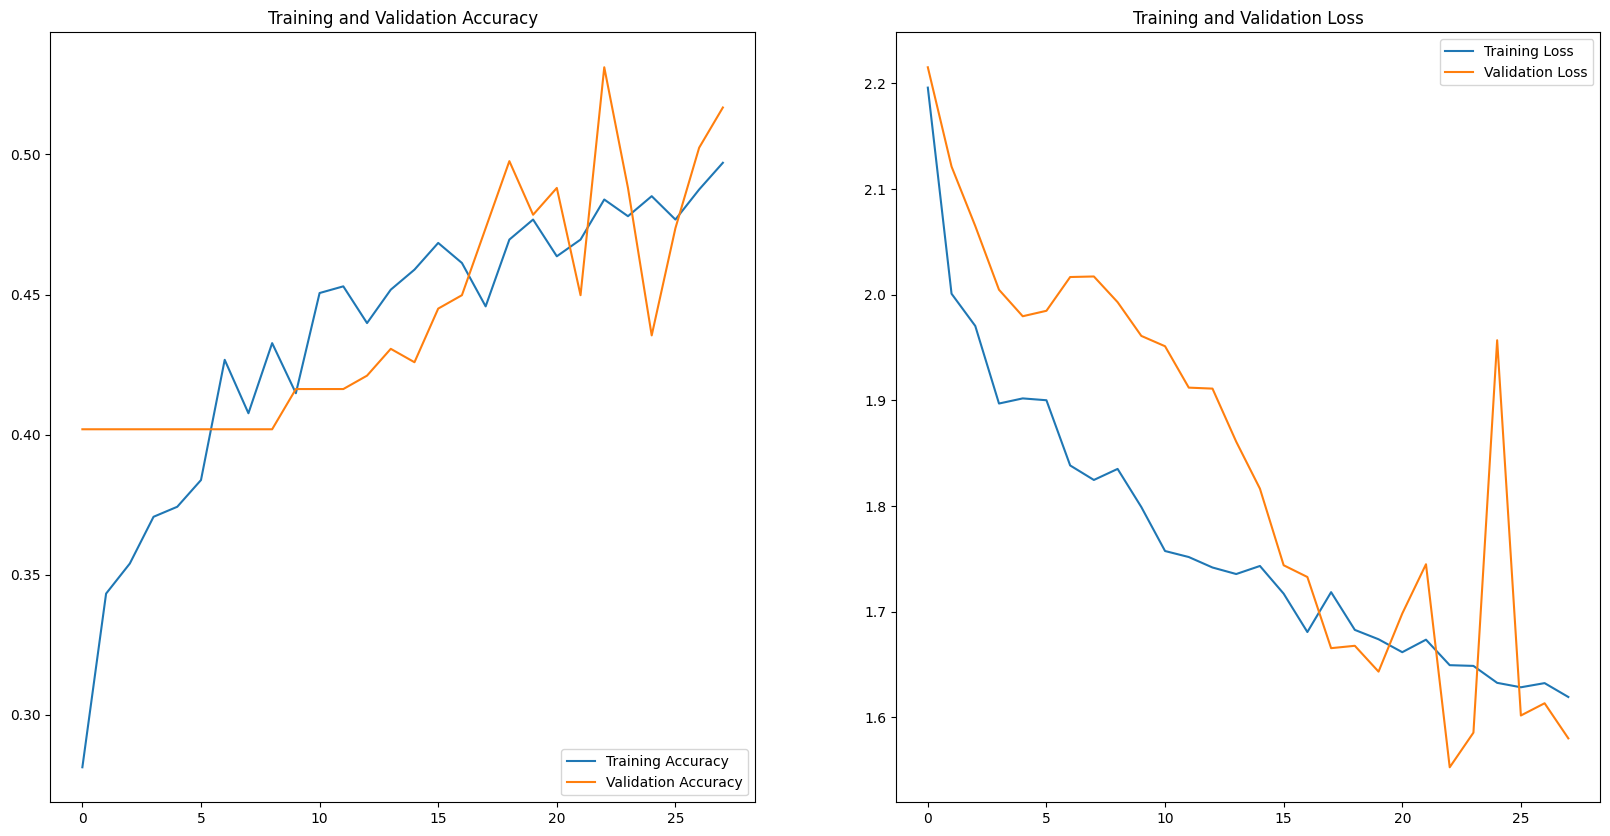

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(28)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_dataset)
print(f'Predictions: {predictions}')

predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step
Predictions: [[0.12621683 0.12536913 0.07234926 ... 0.23320103 0.07942264 0.24556075]
 [0.09583311 0.07789502 0.02071456 ... 0.18406092 0.05541357 0.50441724]
 [0.06499742 0.23239714 0.09252708 ... 0.15068813 0.0306698  0.3552595 ]
 ...
 [0.05048557 0.25895396 0.07424897 ... 0.24089406 0.01231004 0.18451281]
 [0.09826194 0.12032082 0.06771962 ... 0.20200555 0.07844282 0.35711637]
 [0.02808118 0.10053658 0.05061344 ... 0.23677523 0.00901646 0.13580038]]
[8 8 8 8 8 8 8 4 4 4 4 1 8 6 4 4 6 8 8 8 8 4 1 1 8 8 1 8 8 6 4 8 4 6 1 8 8
 8 4 4 8 6 1 8 4 4 4 4 8 8 8 8 4 8 8 8 4 4 4 8 6 4 6 8 8 4 6 1 8 1 8 8 8 8
 8 6 1 8 8 8 6 6 8 6 1 1 8 8 8 8 4 4 8 8 6 6 6 4 4 6 8 8 6 8 4 8 6 8 4 1 8
 4]
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step - accuracy: 0.3560 - loss: 2.0617 - precision_1: 0.4816 - recall_1: 0.1094
Test accuracy: 0.3482142984867096
Test precision: 0.5384615659713745
Test recall: 0.125
